# Breast Cancer Detection With Mammograms

This is a demonstration on how to build a model that gives prediction on breast cancer given a set of mammograms.

The dataset used is the [Augmented INBreast Dataset](https://www.kaggle.com/datasets/eoussama/breast-cancer-mammograms).

A mirror repository for this notebook can be found on [github](https://github.com/gomu-gomu/ma-dl-projet-1).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp /content/drive/MyDrive/Stat_Docs/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download eoussama/breast-cancer-mammograms

Dataset URL: https://www.kaggle.com/datasets/eoussama/breast-cancer-mammograms
License(s): CC-BY-NC-SA-4.0
  0% 0.00/73.0M [00:00<?, ?B/s]
100% 73.0M/73.0M [00:00<00:00, 1.33GB/s]


In [6]:
! unzip /content/breast-cancer-mammograms.zip -d /content/breast-cancer-mammograms > /dev/null

In [7]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   38G   75G  34% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  775M  61% /usr/sbin/docker-init
/dev/sda1        75G   41G   35G  54% /kaggle/input
tmpfs           6.4G  100K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  7.1G  8.0G  48% /content/drive


## Dependencies

In [ ]:
# ! pip install tensorflow==2.12.0

In [8]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
# import keras
from keras.callbacks import CSVLogger
from keras.models import Sequential, load_model
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

## Dataset INBreast Dataset
We have to prepare our dataset and split it in a convenient way. First we start by setting up separate folders fore each sub-category.

In [9]:
output_path = "/colab/working"
input_path = "/content/breast-cancer-mammograms"
data_path = f"{output_path}/split_data"

for split in ['train', 'val', 'test']:
    for cls in ['benign', 'malignant']:
        os.makedirs(os.path.join(data_path, split, cls), exist_ok=True)

def get_files(cls):
    return [f for f in os.listdir(os.path.join(input_path, cls))
           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

benign_files = get_files('benign')
malignant_files = get_files('malignant')

def split_data(files):
    train, temp = train_test_split(files, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    return train, val, test

benign_train, benign_val, benign_test = split_data(benign_files)
malignant_train, malignant_val, malignant_test = split_data(malignant_files)

def copy_files(files, cls, split):
    for f in files:
        src = os.path.join(input_path, cls, f)
        dst = os.path.join(data_path, split, cls, f)
        shutil.copy(src, dst)

copy_files(benign_train, 'benign', 'train')
copy_files(benign_val, 'benign', 'val')
copy_files(benign_test, 'benign', 'test')

copy_files(malignant_train, 'malignant', 'train')
copy_files(malignant_val, 'malignant', 'val')
copy_files(malignant_test, 'malignant', 'test')

print("Dataset split completed!")

Dataset split completed!


### Loading the data
Then we create an image data generator that will scale each pixel's value by 1/255, essentially normalizing them from the standard 0–255 range to a 0–1 range. Then we load the three data collections separately.

In [ ]:
# datagen = ImageDataGenerator(rescale=1./255)

# train = datagen.flow_from_directory(
#     f'{data_path}/train',
#     target_size=(224, 224),
#     class_mode='binary',
#     batch_size=64
# )

# val = datagen.flow_from_directory(
#     f'{data_path}/val',
#     target_size=(224, 224),
#     class_mode='binary',
#     batch_size=64
# )

# test = datagen.flow_from_directory(
#     f'{data_path}/test',
#     target_size=(224, 224),
#     class_mode='binary',
#     batch_size=64
# )

Found 6105 images belonging to 2 classes.
Found 763 images belonging to 2 classes.
Found 764 images belonging to 2 classes.


In [10]:
datagen = ImageDataGenerator(rescale=1./255)

train = datagen.flow_from_directory(
    f'{data_path}/train',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64,
    shuffle = True
)

val = datagen.flow_from_directory(
    f'{data_path}/val',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64
)

test = datagen.flow_from_directory(
    f'{data_path}/test',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64
)

Found 6105 images belonging to 2 classes.
Found 763 images belonging to 2 classes.
Found 764 images belonging to 2 classes.


### Data inspection
Now we fetch the first batch of images and labels out of `train`, and confirm their shape.

In [11]:
imgs, labels = next(train)
imgs.shape

(64, 224, 224, 3)

* **64**: the batch size (number of images).
* **224 × 224**: the height and width of each image, as defined in `target_size=(224, 224)`.
* **3**: the number of color channels (RGB).

We confirm that we only have 2 classes. **Benign** and **Malgnant**.

In [12]:
train.class_indices

{'benign': 0, 'malignant': 1}

Displaying the first image in the training dataset should show us a grayscale scan of a breast, accompanied with the correct class decided by its diagnosis.

Class: 1.0


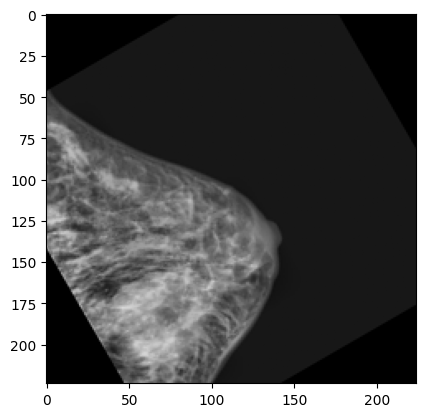

In [13]:
plt.imshow(imgs[0])
print(f'Class: {labels[0]}')

The class is `1.0`, which matches **Malignant** on the class indices of the training dataset.

## Model

We're gonna build a simple Convolutional Neural Network (CNN) for binary classification. First, we add three convolution-and-pooling blocks to extract spatial features from the images. Then, we flatten the feature maps and pass them through a couple of dense (fully connected) layers, including a dropout for regularization. Finally, we use a single output neuron with a sigmoid activation for predicting whether an image is benign or malignant.

* Step 1:

    - We start by initializing a new `Sequential` model, which is a linear stack of layers in Keras.
* Step 2:

    - `Conv2D(32, (3, 3))`: A convolutional layer with 32 filters/kernels, each 3×3 in size.
    - `input_shape=(224,224,3)`: This is the expected shape of the input images. 224×224 resolution, 3 color channels (RGB).
    - `activation='relu'`: Uses the ReLU activation function.
    - `MaxPooling2D(pool_size=(2, 2))`: Reduces the spatial dimensions by taking the maximum value in each 2×2 pool region, effectively halving the height and width.
* Step 3:

    - Similar to the first block, but it doesn't need an input_shape since Keras automatically infers the shape from the previous layer's output.
    - Another 32 filters, each 3×3, followed by a 2×2 max pool to further downsample.
* Step 4:

    - Now we increase the number of filters to 64. A larger number of filters can learn more complex features.
    - Followed by another 2×2 max pool for further spatial reduction.
* Step 5:

    - `Flatten()`: Converts the 3D feature maps (height × width × channels) into a 1D vector, so it can be fed into a dense (fully connected) layer.
    - `Dense(64, activation='relu')`: A fully connected layer with 64 neurons, learning high-level combinations of features.
    - `Dropout(0.5)`: Randomly sets 50% of the neurons to zero during training to reduce overfitting.
    - `Dense(1, activation='sigmoid')`: The final output layer. Since this is a binary classification (benign vs. malignant), we use a single neuron with a sigmoid activation, which outputs a probability between 0 and 1.
* Step 6:

    - `loss='binary_crossentropy'`: The appropriate loss function for binary classification.
    - `optimizer='rmsprop'`: A gradient-based optimization algorithm (alternative to Adam, SGD, etc.).
    - `metrics=['accuracy']`: We track accuracy during training/evaluation.

In [18]:
# build denseNet201
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


In [19]:
base_model = DenseNet201(weights='imagenet', include_top=False)



# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
# x = Dropout(0.5)(x) Keeping the dropouts I didn't get good accuracy
outputs = Dense(1, activation='sigmoid')(x)
# Create the final model
model = Model(inputs=base_model.input, outputs=outputs)





In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

In [ ]:
# model.summary()

In [ ]:
# from tensorflow.keras.metrics import AUC, Precision, Recall


# # Step 1 - Initializing model
# model = Sequential()

# # Step 2 - First Convolution + MaxPooling
# model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Step 3 - Second Convolution + MaxPooling
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Step 4 - Third Convolution + MaxPooling
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Step 5 - Flatten + Dense + Dropout + Output
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Step 6 - Compile
# # Step 6 - Compile


# # additional metrics
# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])
# model.summary()

- **Output Shape**: The size of the activation maps after each layer.

- **Param #**: The number of trainable parameters (weights and biases).

> Notice that most of the parameters (over 2.7 million) are in the fully connected layer (dense_6), which converts the flattened feature maps to 64 neurons.

- **Total params**: The sum of all parameters in the network.

## Training

In this step we will train the CNN for 100 epochs while logging metrics to a CSV file (training.log) for analysis, and then saves the trained model for future use.

In [21]:


# Calculating how many batches (steps) makeup one full pass (epoch) through our training and validation datasets.
# STEP_SIZE_TRAIN = train.n // train.batch_size
# STEP_SIZE_VAL = val.n // val.batch_size



# Recalculate how many batches make up one full pass (epoch) through our training and validation datasets.
STEP_SIZE_TRAIN = len(train)  # Instead of train.n // train.batch_size
STEP_SIZE_VAL = len(val)



os.makedirs(os.path.join(output_path, 'logs'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'out'), exist_ok=True)

# This callback records loss, accuracy, and other metrics for each epoch into a CSV file named training.log.
# It's helpful for tracking and comparing training progress over time.
csv_logger = CSVLogger(f'{output_path}/logs/training.log', separator=',', append=False)

# history = model.fit_generator(generator = train,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=test,
#                     validation_steps=STEP_SIZE_VAL,
#                     epochs = 50,
#                     # epochs=100,
#                     callbacks=[csv_logger])


history = model.fit(
    train,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=val,
    validation_steps=STEP_SIZE_VAL,
    epochs=50,
    callbacks=[csv_logger,
               EarlyStopping(monitor='val_auc', patience=15, verbose=1, mode='max', restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
              ModelCheckpoint(f'{output_path}/out/best_model.h5', monitor='val_auc',
              save_best_only=True, mode='max', verbose=1)]
)







model.save(f'{output_path}/out/model.h5')



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6472 - auc: 0.6248 - loss: 0.7092 - precision: 0.7056 - recall: 0.7936
Epoch 1: val_auc improved from -inf to 0.89292, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.6477 - auc: 0.6256 - loss: 0.7080 - precision: 0.7060 - recall: 0.7941 - val_accuracy: 0.8322 - val_auc: 0.8929 - val_loss: 0.4518 - val_precision: 0.8762 - val_recall: 0.8728 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7607 - auc: 0.8068 - loss: 0.4945 - precision: 0.7922 - recall: 0.8650
Epoch 2: val_auc improved from 0.89292 to 0.92818, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - accuracy: 0.7609 - auc: 0.8071 - loss: 0.4941 - precision: 0.7924 - recall: 0.8652 - val_accuracy: 0.8480 - val_auc: 0.9282 - val_loss: 0.3303 - val_precision: 0.8835 - val_recall: 0.8904 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8241 - auc: 0.8937 - loss: 0.3798 - precision: 0.8420 - recall: 0.9099
Epoch 3: val_auc improved from 0.92818 to 0.95489, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 273ms/step - accuracy: 0.8242 - auc: 0.8938 - loss: 0.3798 - precision: 0.8420 - recall: 0.9099 - val_accuracy: 0.8925 - val_auc: 0.9549 - val_loss: 0.2667 - val_precision: 0.9198 - val_recall: 0.9198 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8661 - auc: 0.9332 - loss: 0.3088 - precision: 0.8844 - recall: 0.9193
Epoch 4: val_auc improved from 0.95489 to 0.97506, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.8660 - auc: 0.9332 - loss: 0.3089 - precision: 0.8844 - recall: 0.9192 - val_accuracy: 0.9135 - val_auc: 0.9751 - val_loss: 0.2125 - val_precision: 0.9287 - val_recall: 0.9432 - learning_rate: 0.0010
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8856 - auc: 0.9447 - loss: 0.2773 - precision: 0.9007 - recall: 0.9332
Epoch 5: val_auc improved from 0.97506 to 0.97974, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.8855 - auc: 0.9447 - loss: 0.2773 - precision: 0.9007 - recall: 0.9331 - val_accuracy: 0.9122 - val_auc: 0.9797 - val_loss: 0.2017 - val_precision: 0.9022 - val_recall: 0.9746 - learning_rate: 0.0010
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8948 - auc: 0.9591 - loss: 0.2440 - precision: 0.9129 - recall: 0.9305
Epoch 6: val_auc improved from 0.97974 to 0.98581, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.8948 - auc: 0.9591 - loss: 0.2439 - precision: 0.9129 - recall: 0.9306 - val_accuracy: 0.9436 - val_auc: 0.9858 - val_loss: 0.1589 - val_precision: 0.9699 - val_recall: 0.9452 - learning_rate: 0.0010
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9116 - auc: 0.9698 - loss: 0.2108 - precision: 0.9263 - recall: 0.9429
Epoch 7: val_auc improved from 0.98581 to 0.98715, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - accuracy: 0.9115 - auc: 0.9698 - loss: 0.2108 - precision: 0.9263 - recall: 0.9429 - val_accuracy: 0.9332 - val_auc: 0.9871 - val_loss: 0.1505 - val_precision: 0.9440 - val_recall: 0.9569 - learning_rate: 0.0010
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9098 - auc: 0.9716 - loss: 0.2026 - precision: 0.9272 - recall: 0.9374
Epoch 8: val_auc improved from 0.98715 to 0.98851, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.9099 - auc: 0.9716 - loss: 0.2026 - precision: 0.9273 - recall: 0.9375 - val_accuracy: 0.9279 - val_auc: 0.9885 - val_loss: 0.1720 - val_precision: 0.9101 - val_recall: 0.9902 - learning_rate: 0.0010
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9189 - auc: 0.9733 - loss: 0.1971 - precision: 0.9280 - recall: 0.9501
Epoch 9: val_auc improved from 0.98851 to 0.99155, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 291ms/step - accuracy: 0.9189 - auc: 0.9733 - loss: 0.1971 - precision: 0.9280 - recall: 0.9501 - val_accuracy: 0.9436 - val_auc: 0.9915 - val_loss: 0.1217 - val_precision: 0.9432 - val_recall: 0.9746 - learning_rate: 0.0010
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9246 - auc: 0.9781 - loss: 0.1772 - precision: 0.9374 - recall: 0.9517
Epoch 10: val_auc improved from 0.99155 to 0.99405, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - accuracy: 0.9247 - auc: 0.9781 - loss: 0.1772 - precision: 0.9374 - recall: 0.9517 - val_accuracy: 0.9620 - val_auc: 0.9941 - val_loss: 0.1107 - val_precision: 0.9859 - val_recall: 0.9569 - learning_rate: 0.0010
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9371 - auc: 0.9850 - loss: 0.1473 - precision: 0.9501 - recall: 0.9566
Epoch 11: val_auc did not improve from 0.99405
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.9371 - auc: 0.9849 - loss: 0.1474 - precision: 0.9501 - recall: 0.9566 - val_accuracy: 0.9672 - val_auc: 0.9940 - val_loss: 0.0951 - val_precision: 0.9709 - val_recall: 0.9804 - learning_rate: 0.0010
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9290 - auc: 0.9789 - loss: 0.1731 - precision: 0.9396 - recall: 0.9556
Epoch 12: val_auc did not improve from 0.99405
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.9290 - auc: 0.9789 - loss: 0.1732 - precision: 0.9396 - recall

96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.9371 - auc: 0.9833 - loss: 0.1545 - precision: 0.9450 - recall: 0.9617 - val_accuracy: 0.9685 - val_auc: 0.9965 - val_loss: 0.0780 - val_precision: 0.9710 - val_recall: 0.9824 - learning_rate: 0.0010
Epoch 15/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9345 - auc: 0.9836 - loss: 0.1526 - precision: 0.9429 - recall: 0.9593
Epoch 15: val_auc improved from 0.99646 to 0.99660, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9345 - auc: 0.9836 - loss: 0.1526 - precision: 0.9430 - recall: 0.9593 - val_accuracy: 0.9699 - val_auc: 0.9966 - val_loss: 0.0782 - val_precision: 0.9747 - val_recall: 0.9804 - learning_rate: 0.0010
Epoch 16/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9340 - auc: 0.9814 - loss: 0.1606 - precision: 0.9415 - recall: 0.9616
Epoch 16: val_auc improved from 0.99660 to 0.99744, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.9339 - auc: 0.9814 - loss: 0.1608 - precision: 0.9415 - recall: 0.9616 - val_accuracy: 0.9764 - val_auc: 0.9974 - val_loss: 0.0797 - val_precision: 0.9881 - val_recall: 0.9765 - learning_rate: 0.0010
Epoch 17/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9353 - auc: 0.9831 - loss: 0.1562 - precision: 0.9416 - recall: 0.9623
Epoch 17: val_auc did not improve from 0.99744
96/96 ━━━━━━━━━━━━━━━━━━━━ 37s 269ms/step - accuracy: 0.9354 - auc: 0.9831 - loss: 0.1561 - precision: 0.9417 - recall: 0.9623 - val_accuracy: 0.9581 - val_auc: 0.9967 - val_loss: 0.1009 - val_precision: 0.9411 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 18/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9345 - auc: 0.9823 - loss: 0.1572 - precision: 0.9442 - recall: 0.9594
Epoch 18: val_auc did not improve from 0.99744
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - accuracy: 0.9345 - auc: 0.9823 - loss: 0.1571 - precision: 0.9443 - recall

96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.9455 - auc: 0.9844 - loss: 0.1429 - precision: 0.9453 - recall: 0.9738 - val_accuracy: 0.9672 - val_auc: 0.9981 - val_loss: 0.0687 - val_precision: 0.9899 - val_recall: 0.9609 - learning_rate: 5.0000e-04
Epoch 21/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9678 - auc: 0.9925 - loss: 0.0950 - precision: 0.9700 - recall: 0.9819
Epoch 21: val_auc improved from 0.99812 to 0.99821, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.9678 - auc: 0.9925 - loss: 0.0949 - precision: 0.9700 - recall: 0.9819 - val_accuracy: 0.9803 - val_auc: 0.9982 - val_loss: 0.0533 - val_precision: 0.9882 - val_recall: 0.9824 - learning_rate: 5.0000e-04
Epoch 22/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9730 - auc: 0.9959 - loss: 0.0728 - precision: 0.9761 - recall: 0.9840
Epoch 22: val_auc improved from 0.99821 to 0.99863, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 290ms/step - accuracy: 0.9730 - auc: 0.9959 - loss: 0.0728 - precision: 0.9760 - recall: 0.9840 - val_accuracy: 0.9843 - val_auc: 0.9986 - val_loss: 0.0454 - val_precision: 0.9864 - val_recall: 0.9902 - learning_rate: 5.0000e-04
Epoch 23/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9710 - auc: 0.9958 - loss: 0.0760 - precision: 0.9705 - recall: 0.9868
Epoch 23: val_auc improved from 0.99863 to 0.99896, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - accuracy: 0.9710 - auc: 0.9958 - loss: 0.0760 - precision: 0.9705 - recall: 0.9867 - val_accuracy: 0.9830 - val_auc: 0.9990 - val_loss: 0.0443 - val_precision: 0.9940 - val_recall: 0.9804 - learning_rate: 5.0000e-04
Epoch 24/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9787 - auc: 0.9966 - loss: 0.0617 - precision: 0.9801 - recall: 0.9882
Epoch 24: val_auc improved from 0.99896 to 0.99903, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 286ms/step - accuracy: 0.9786 - auc: 0.9966 - loss: 0.0617 - precision: 0.9801 - recall: 0.9881 - val_accuracy: 0.9830 - val_auc: 0.9990 - val_loss: 0.0520 - val_precision: 0.9960 - val_recall: 0.9785 - learning_rate: 5.0000e-04
Epoch 25/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9801 - auc: 0.9968 - loss: 0.0608 - precision: 0.9802 - recall: 0.9903
Epoch 25: val_auc improved from 0.99903 to 0.99943, saving model to /colab/working/out/best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 299ms/step - accuracy: 0.9801 - auc: 0.9968 - loss: 0.0608 - precision: 0.9801 - recall: 0.9902 - val_accuracy: 0.9869 - val_auc: 0.9994 - val_loss: 0.0353 - val_precision: 0.9941 - val_recall: 0.9863 - learning_rate: 5.0000e-04
Epoch 26/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9738 - auc: 0.9965 - loss: 0.0668 - precision: 0.9762 - recall: 0.9848
Epoch 26: val_auc did not improve from 0.99943
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.9738 - auc: 0.9965 - loss: 0.0667 - precision: 0.9762 - recall: 0.9848 - val_accuracy: 0.9908 - val_auc: 0.9992 - val_loss: 0.0358 - val_precision: 0.9961 - val_recall: 0.9902 - learning_rate: 5.0000e-04
Epoch 27/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9769 - auc: 0.9967 - loss: 0.0668 - precision: 0.9787 - recall: 0.9871
Epoch 27: val_auc did not improve from 0.99943
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.9770 - auc: 0.9967 - loss: 0.0668 - precision: 0.9787 

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9788 - auc: 0.9982 - loss: 0.0504 - precision: 0.9800 - recall: 0.9884 - val_accuracy: 0.9934 - val_auc: 0.9995 - val_loss: 0.0259 - val_precision: 0.9961 - val_recall: 0.9941 - learning_rate: 5.0000e-04
Epoch 37/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9827 - auc: 0.9979 - loss: 0.0502 - precision: 0.9819 - recall: 0.9929
Epoch 37: val_auc did not improve from 0.99947
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.9827 - auc: 0.9979 - loss: 0.0502 - precision: 0.9820 - recall: 0.9929 - val_accuracy: 0.9843 - val_auc: 0.9993 - val_loss: 0.0342 - val_precision: 0.9883 - val_recall: 0.9883 - learning_rate: 5.0000e-04
Epoch 38/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9852 - auc: 0.9983 - loss: 0.0432 - precision: 0.9865 - recall: 0.9916
Epoch 38: val_auc did not improve from 0.99947
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.9851 - auc: 0.9983 - loss: 0.0433 - precision: 0.9865 

96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step - accuracy: 0.9837 - auc: 0.9984 - loss: 0.0434 - precision: 0.9826 - recall: 0.9925 - val_accuracy: 0.9895 - val_auc: 0.9996 - val_loss: 0.0266 - val_precision: 0.9922 - val_recall: 0.9922 - learning_rate: 5.0000e-04
Epoch 41/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9851 - auc: 0.9983 - loss: 0.0447 - precision: 0.9848 - recall: 0.9927
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 41: val_auc did not improve from 0.99956
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.9851 - auc: 0.9983 - loss: 0.0447 - precision: 0.9848 - recall: 0.9928 - val_accuracy: 0.9934 - val_auc: 0.9993 - val_loss: 0.0263 - val_precision: 0.9941 - val_recall: 0.9961 - learning_rate: 5.0000e-04
Epoch 42/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9866 - auc: 0.9983 - loss: 0.0432 - precision: 0.9849 - recall: 0.9952
Epoch 42: val_auc did not improve from 0.99956
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 3

96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 283ms/step - accuracy: 0.9904 - auc: 0.9995 - loss: 0.0264 - precision: 0.9900 - recall: 0.9955 - val_accuracy: 0.9908 - val_auc: 0.9998 - val_loss: 0.0239 - val_precision: 0.9922 - val_recall: 0.9941 - learning_rate: 2.5000e-04
Epoch 44/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9880 - auc: 0.9995 - loss: 0.0291 - precision: 0.9864 - recall: 0.9963
Epoch 44: val_auc did not improve from 0.99976
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.9881 - auc: 0.9995 - loss: 0.0291 - precision: 0.9865 - recall: 0.9963 - val_accuracy: 0.9908 - val_auc: 0.9985 - val_loss: 0.0305 - val_precision: 0.9941 - val_recall: 0.9922 - learning_rate: 2.5000e-04
Epoch 45/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9930 - auc: 0.9997 - loss: 0.0211 - precision: 0.9915 - recall: 0.9983
Epoch 45: val_auc did not improve from 0.99976
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.9930 - auc: 0.9997 - loss: 0.0212 - precision: 0.9915 

96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.9931 - auc: 0.9995 - loss: 0.0217 - precision: 0.9931 - recall: 0.9966 - val_accuracy: 0.9921 - val_auc: 0.9998 - val_loss: 0.0227 - val_precision: 0.9980 - val_recall: 0.9902 - learning_rate: 1.2500e-04
Epoch 50/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9954 - auc: 0.9998 - loss: 0.0160 - precision: 0.9943 - recall: 0.9990
Epoch 50: val_auc did not improve from 0.99979
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.9954 - auc: 0.9998 - loss: 0.0160 - precision: 0.9943 - recall: 0.9990 - val_accuracy: 0.9921 - val_auc: 0.9997 - val_loss: 0.0252 - val_precision: 0.9961 - val_recall: 0.9922 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 49.


To determine the step sizes, take note of the following:






- `train.n` and `val.n`: The total number of samples in each dataset.
- `train.batch_size` and `val.batch_size`: The batch size.
- Using integer division `//` gives you the number of batches needed.

As for fitting the model:
- `model.fit_generator(...)`: Trains the model using the data generated from train (the training image generator) in batches.
- `steps_per_epoch=STEP_SIZE_TRAIN`: How many steps (batches) to run per epoch during training.
- `validation_data=test` and `validation_steps=STEP_SIZE_VAL`: Here, you're using the test generator for validation, with STEP_SIZE_VAL batches per epoch.
- `epochs=100`: The number of times the model will see the entire dataset.
- `callbacks=[csv_logger]`: Logs each epoch's metrics to the CSV file.

We can visualize how our model's accuracy changes over the course of training. By plotting both the training and validation accuracy, we'll get a clear picture of how well the model is fitting to the training data and how effectively it generalizes to unseen data.

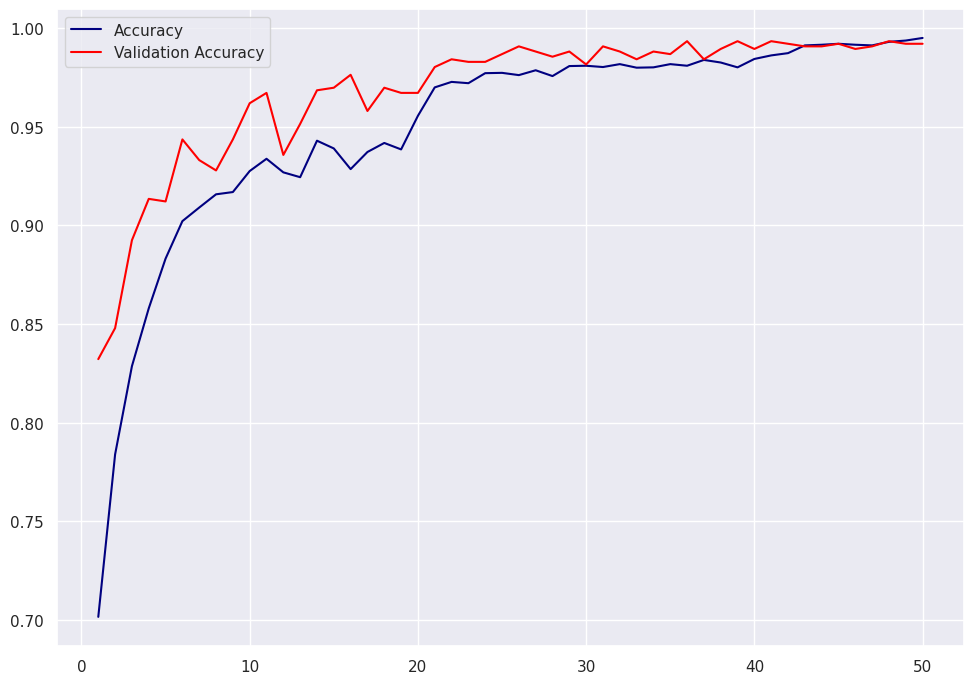

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(history.history['accuracy'])+1,1), history.history['accuracy'], color='navy', label = 'Accuracy')
plt.plot(np.arange(1, len(history.history['accuracy'])+1,1), history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.legend()

The plot shows two lines: one for the training **accuracy** (in navy) and another for the validation accuracy (in red). As the number of epochs increases, we can observe whether the model converges, if it overfits (training accuracy outpacing validation accuracy), or if both accuracies improve steadily over time. This helps us assess the model's performance and decide on further tuning.

From the plot, we can see that the training accuracy (blue line) reaches near-perfect levels, while the validation accuracy (red line) plateaus around the high 80s to low 90s. This suggests the model is learning effectively but also overfitting somewhat—its performance on unseen data (validation accuracy) isn't as high as on the training set. Even so, the validation accuracy still remains robust, indicating that the model generally performs well at classifying new examples despite not matching the near-perfect training performance.

We can do the same with the saved model. We can read back the CSV file (training.log) that was generated by the `CSVLogger` during training. Each row in this file corresponds to an epoch, and the columns contain metrics like loss, accuracy, validation loss, and validation accuracy.

In [23]:
log_data = pd.read_csv(f'{output_path}/logs/training.log', sep=',', engine='python')
log_data

,epoch,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
0,0,0.701556,0.703027,0.600626,0.743816,0.845684,0.832241,0.892915,0.451767,0.876228,0.872798
1,1,0.783948,0.836949,0.457210,0.811376,0.882612,0.847969,0.928175,0.330304,0.883495,0.890411
2,2,0.828665,0.898549,0.373136,0.850012,0.903644,0.892529,0.954893,0.266750,0.919765,0.919765
3,3,0.857985,0.930434,0.312851,0.881573,0.910247,0.913499,0.975061,0.212483,0.928709,0.943249
4,4,0.883210,0.945953,0.275245,0.900190,0.928589,0.912189,0.979735,0.201747,0.902174,0.974560
5,5,0.902211,0.960937,0.236369,0.918705,0.936904,0.943644,0.985812,0.158916,0.969880,0.945205
6,6,0.909091,0.968377,0.213884,0.924352,0.941306,0.933159,0.987148,0.150496,0.944015,0.956947
7,7,0.915807,0.972896,0.195880,0.933544,0.941306,0.927916,0.988511,0.171955,0.910072,0.990215
8,8,0.916953,0.971843,0.199547,0.928674,0.948887,0.943644,0.991547,0.121694,0.943182,0.974560
9,9,0.927600,0.978763,0.174096,0.941205,0.951333,0.961992,0.994052,0.110676,0.985887,0.956947


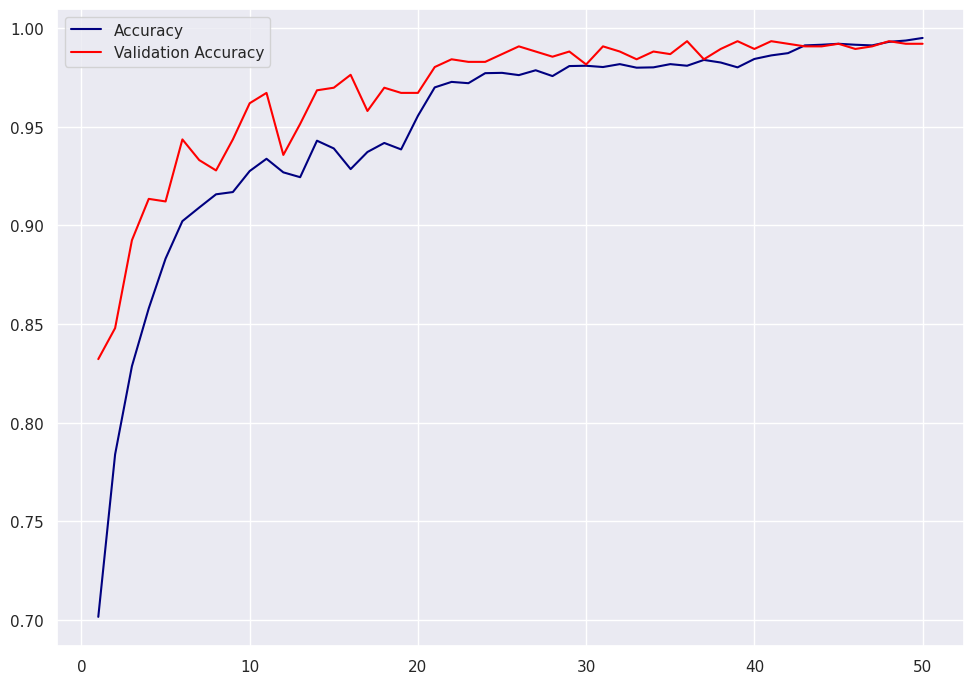

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(log_data['accuracy'])+1,1), log_data['accuracy'], color='navy', label = 'Accuracy')
plt.plot(np.arange(1, len(log_data['accuracy'])+1,1), log_data['val_accuracy'], color='red', label='Validation Accuracy')
plt.legend()

Again, visualizing how our model's **training loss** (in navy) compares to the **validation loss** (in red) over each epoch of training. By charting both curves, we can spot whether the model is successfully generalizing (both losses decreasing together) or if it begins to overfit (training loss keeps going down while validation loss rises). This step is essential to ensure our model is learning appropriately and to guide further tuning.

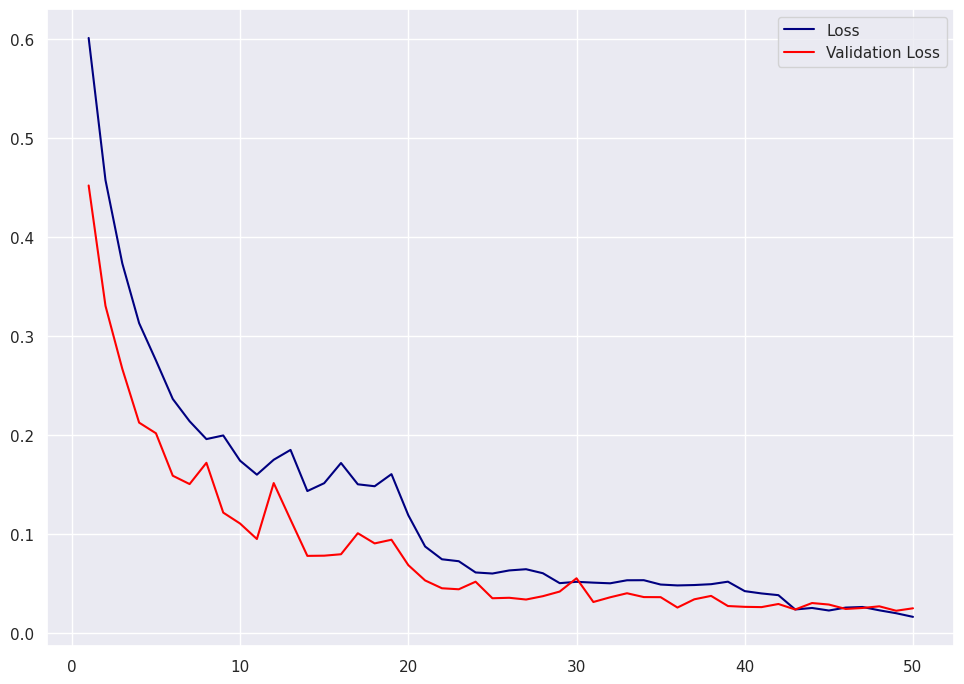

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(history.history['loss'])+1,1), history.history['loss'], color='navy', label = 'Loss')
plt.plot(np.arange(1, len(history.history['loss'])+1,1), history.history['val_loss'], color='red', label='Validation Loss')
plt.legend()

From this plot, it's clear that the **training loss** (blue) steadily goes down to very low values, indicating the model is fitting the training data extremely well. However, the **validation loss** (red) varies up and down rather than following the same steady downward trend, suggesting the model is **overfitting** and not generalizing as consistently to unseen data. The spikes in the validation loss can occur for various reasons (e.g., data variability, small validation sets, or model instability), but the key takeaway is that while the model memorizes the training set effectively, its performance on new data is less stable.

Doing the same again with the logged data.

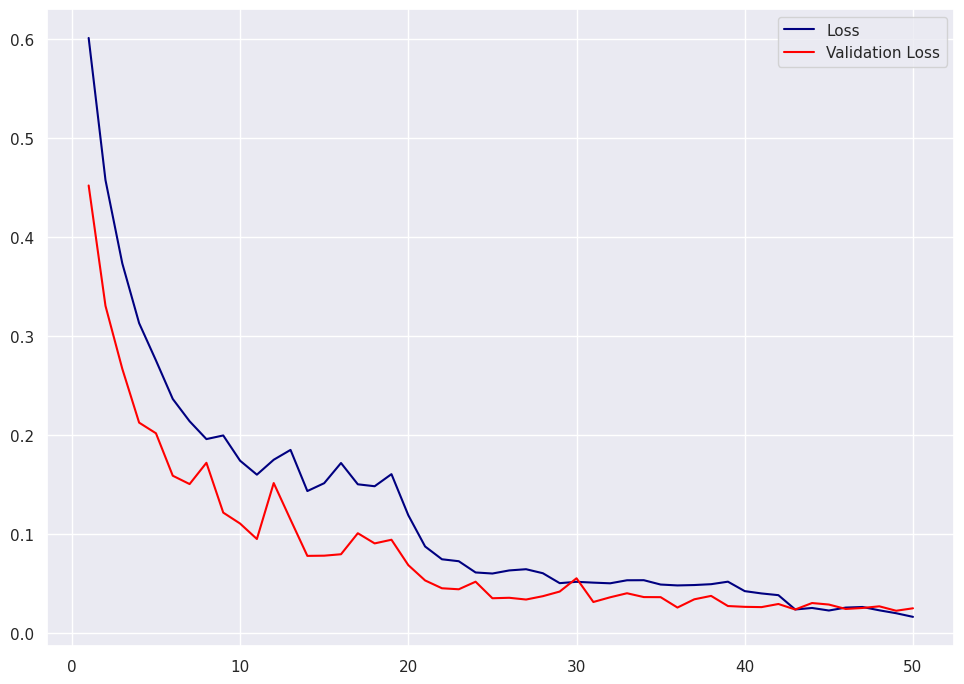

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(log_data['loss'])+1,1), log_data['loss'], color='navy', label = 'Loss')
plt.plot(np.arange(1, len(log_data['loss'])+1,1), log_data['val_loss'], color='red', label='Validation Loss')
plt.legend()

In [27]:
# print classification report before hibernation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Load the trained model
from tensorflow.keras.models import load_model
model = load_model(f'{output_path}/out/model.h5')

# Step 2: Prepare the test data generator
test_generator = test  # Your existing test data generator

# Step 3: Predict the probabilities on the test set
# Note: Use predict() with batch size as needed
pred_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# For binary classification, convert probabilities to class labels
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Step 4: Get true labels
true_labels = test_generator.classes

# Step 5: Generate classification report
report = classification_report(true_labels, pred_labels, target_names=['benign', 'malignant'])
print("Classification Report:\n", report)

# Optional: Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("INBreast Confusion Matrix:\n", cm)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step
Classification Report:
               precision    recall  f1-score   support

      benign       0.34      0.34      0.34       252
   malignant       0.67      0.67      0.67       512

    accuracy                           0.56       764
   macro avg       0.50      0.50      0.50       764
weighted avg       0.56      0.56      0.56       764

INBreast Confusion Matrix:
 [[ 86 166]
 [170 342]]


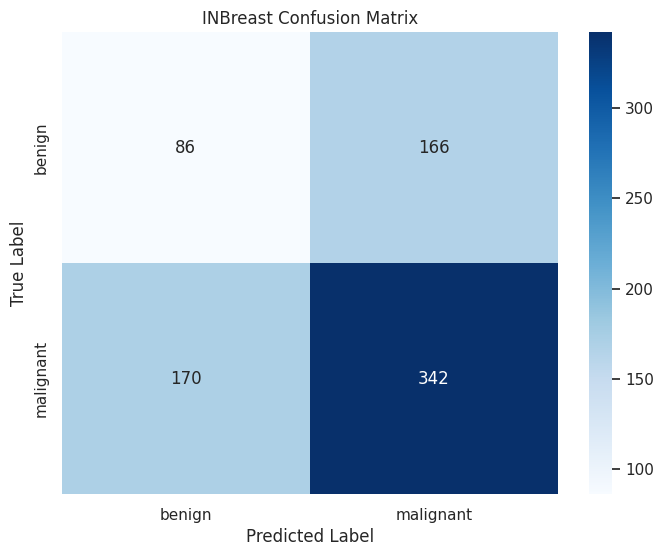

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('INBreast Confusion Matrix')
plt.show()

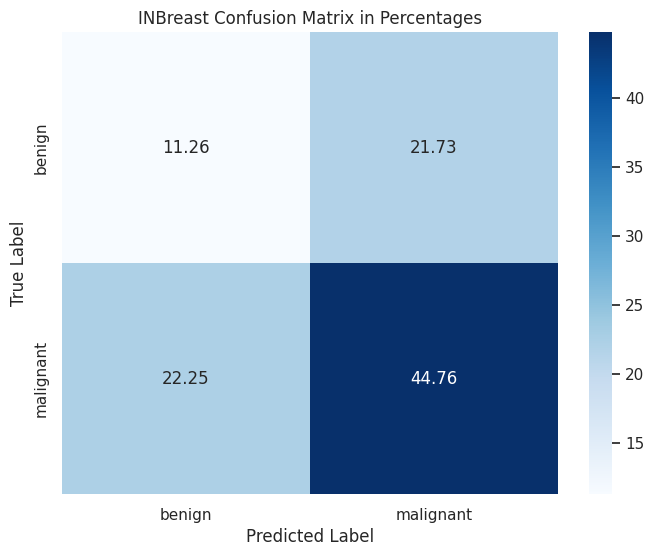

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Normalize the confusion matrix to percentages
cm_percentage = (cm.astype('float') / cm.sum()) * 100

# Plotting the confusion matrix as percentages
plt.figure(figsize=(8,6))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('INBreast Confusion Matrix in Percentages')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step


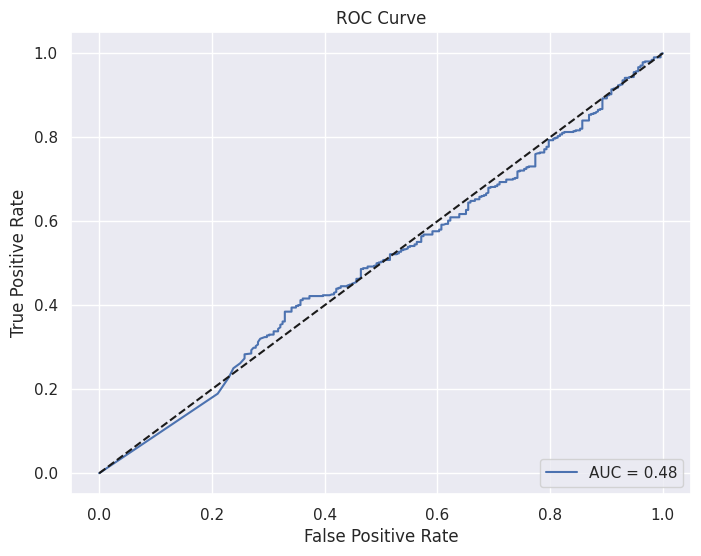

In [32]:
# get true labels
y_true = test_generator.classes

# get predicted labels
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Calculates the AUC score
auc_score = auc(fpr, tpr)


fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


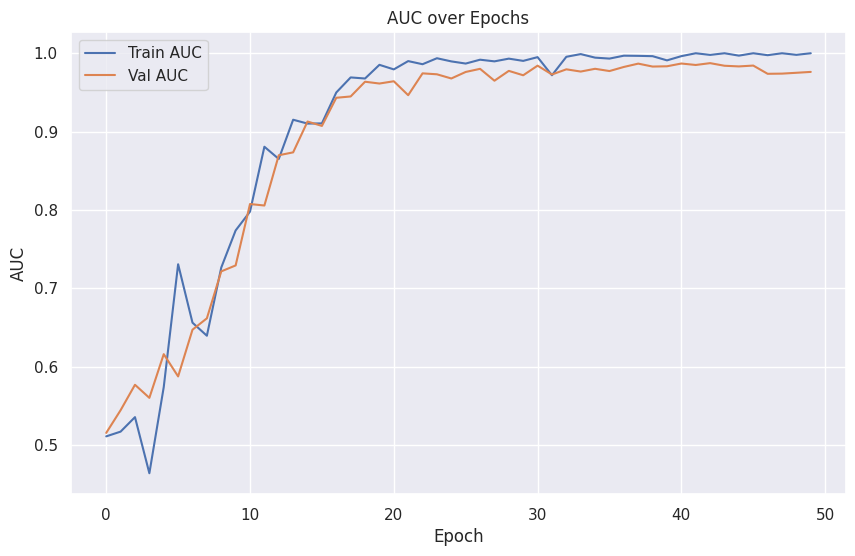

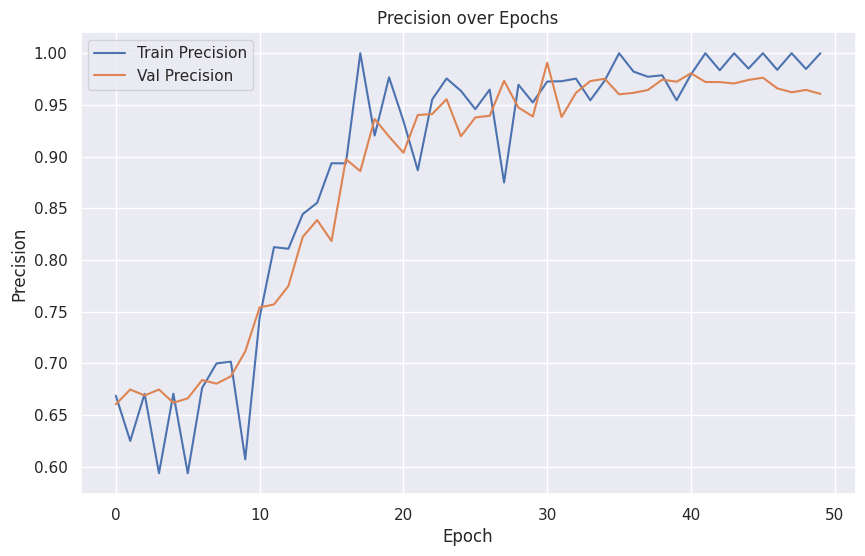

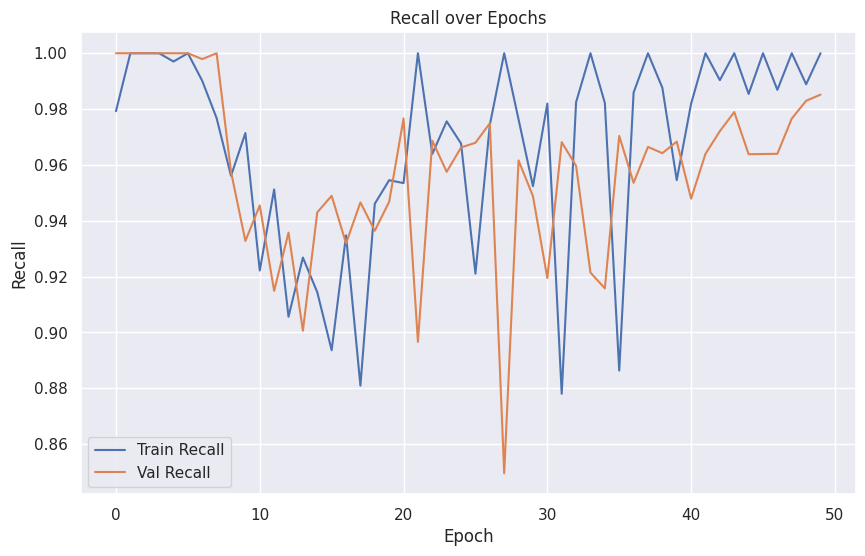

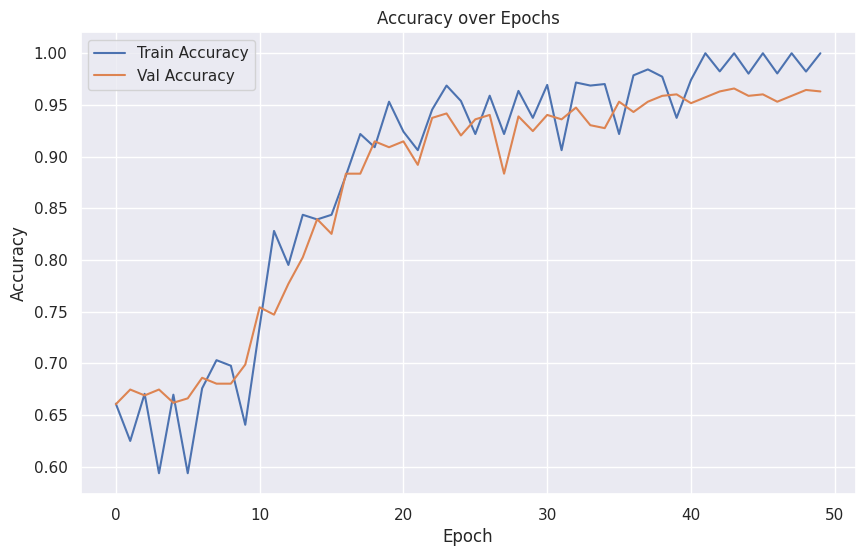

In [ ]:
import matplotlib.pyplot as plt

# Plot AUC
plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.savefig("AUC_Epochs.png", dpi=300)
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig("Precision_Epochs.png", dpi=300)
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.savefig("Recall_Epochs.png", dpi=300)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("Accuracy_Epochs.png", dpi=300)
plt.show()


In [ ]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import numpy as np
import matplotlib.pyplot as plt

# Predict on all validation data
y_pred_prob = model.predict(test, verbose=1)

# Class prediction (binary threshold)
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()

# Ground truth labels
y_true = test.classes  # length = test.n

# Ensure alignment (optional but safe)
assert len(y_true) == len(y_pred_class)

# Metrics
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1 Score:  {f1:.4f}")
print(f"Test AUC:       {auc_score:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
Test Precision: 0.6743
Test Recall:    0.6914
Test F1 Score:  0.6827
Test AUC:       0.4850


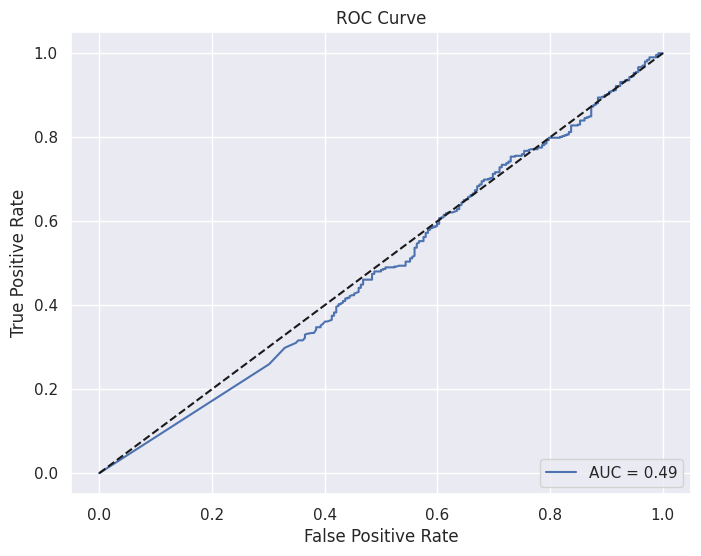

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Hibernation

We can load our previously saved model from disk, then extract all the images and labels from our test generator into NumPy arrays. This prepares our entire test set in a convenient format for further evaluation or predictions.

In [ ]:
# Loading the previously saved model from the specified path. This includes the architecture, weights, and training configuration (if any).
restored_model = load_model(f'{output_path}/out/model.h5')

# Calculating how many batches you need to go through in order to cover our entire test set
steps = test.n//test.batch_size

# Reseting the test generator to start yielding batches from the first image again. This is useful if the generator's internal index was advanced by previous calls (e.g., during validation).
test.reset()

# Collecting the test data
X_test, y_test = [], []
for i in range(steps):
    a , b = test.next()
    X_test.extend(a)
    y_test.extend(b)

# Converting lists to NumPy arrays
X_test, y_test = np.array(X_test), np.array(y_test)

AttributeError: 'DirectoryIterator' object has no attribute 'next'

We can save our test data arrays (X_test and y_test) to disk using `pickle.dump` and then reload them with `pickle.load`.

In [ ]:
# Pickling the model
pickle.dump(X_test, open(f'{output_path}/out/X_test.pkl', 'wb'))
pickle.dump(y_test, open(f'{output_path}/out/y_test.pkl', 'wb'))

# Reloading the model to ensure not thing is corrupt
X_test = pickle.load(open(f'{output_path}/out/X_test.pkl', 'rb'))
y_test = pickle.load(open(f'{output_path}/out/y_test.pkl', 'rb'))

print(X_test.shape, y_test.shape)

AttributeError: 'list' object has no attribute 'shape'

- `pickle.dump(...)`: Serializes (saves) Python objects to a file in a binary format.
- `'wb'`: Means write binary.
- `pickle.load(...)`: Deserializes (loads) the data back from the pickle files into memory.
- `'rb'`: Means read binary.

Result:

- **(704, 224, 224, 3)**: There are 704 images, each 224×224 pixels in size with 3 color channels (RGB).
- **(704,)**: The corresponding labels array for these images has 704 labels.

## Evaluation

We can evaluate the trained model on the full test dataset (`X_test`, `y_test`) and print its performance metrics. Specifically, we `model.evaluate(...)` to obtain the final **loss** and **accuracy** on unseen data, giving us a measure of how well our model generalizes beyond the training set.

### Evaluation the model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

KeyError: 'pop from an empty set'

The above function runs the model on the test data (`X_test` and corresponding labels `y_test`) and returns a list (or tuple) of metrics. In this case, because our model was compiled with `loss='binary_crossentropy'` and `metrics=['accuracy']`, `score[0]` will be the test loss and `score[1]` will be the test accuracy. `verbose=0` means it will not print any progress bar or additional information during evaluation.

Test loss is about **0.48672**, which is a moderate number (lower is typically better). Test accuracy is about **0.97727**, suggesting our model correctly classifies around **97%** of the test samples. This indicates a solid performance on this binary classification task.

### Evaluating the saved model

In [ ]:
score = restored_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

KeyError: 'pop from an empty set'

Evidently, the saved model would yeild the same results.

## Prediction

We can use our trained model to generate predicted probabilities for each image in the test set. Since this is a binary classification problem, each number represents the model's estimated likelihood that the image belongs to class **1** (the **Malignant** class).

### Prediction with the model

In [ ]:
y_pred_prob = model.predict(X_test)
print(y_pred_prob)

KeyError: 'pop from an empty set'

### Prediction with the saved model

In [ ]:
y_pred_prob = restored_model.predict(X_test)
print(y_pred_prob)

KeyError: 'pop from an empty set'

Let's plot two sets of points for each test sample (indexed on the x-axis):

- `y_pred_prob` (red dots): These are the predicted probabilities for each sample. A value near 1 indicates the model believes the image is likely in class **1** (**Malignant**), and a value near 0 indicates the model thinks it's class **0** (**Bengin**).
- `y_test` (blue dots): These are the actual labels (ground truth), which are 0 or 1 in a binary classification. Here, each blue dot at the top represents an actual label of "1" while each blue dot along the bottom represents "0"

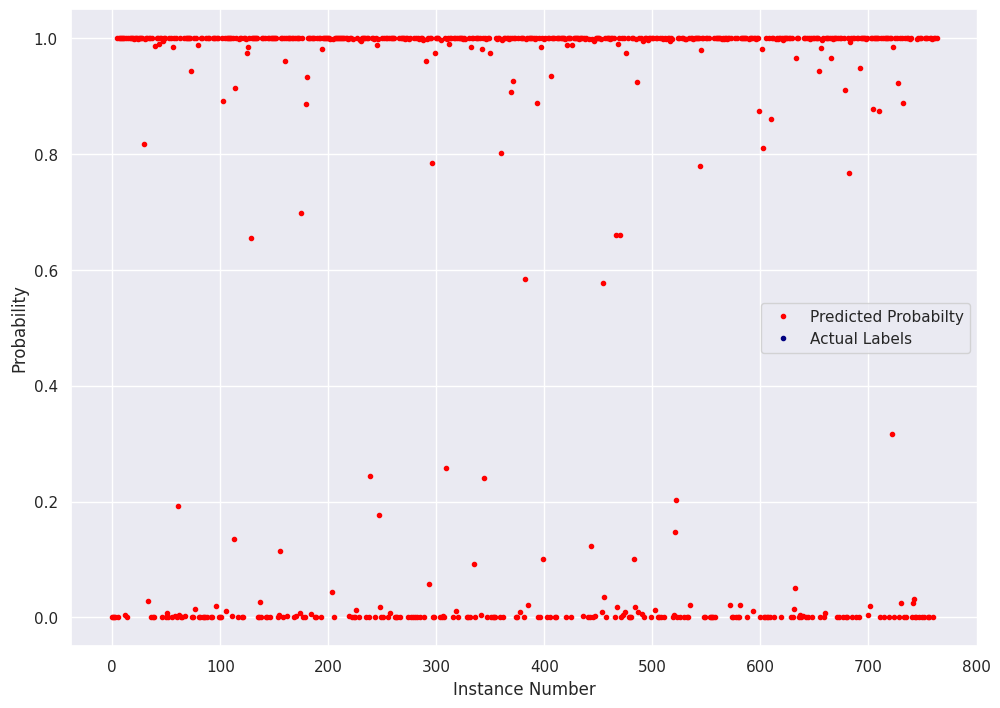

In [ ]:
plt.plot(y_pred_prob,'.', color='red', label='Predicted Probabilty')
plt.plot(y_test, '.', color='navy', label='Actual Labels')
plt.xlabel('Instance Number')
plt.ylabel('Probability')
plt.legend()

## Thresholding

Inspecting the Ground Truth Labels:

In [ ]:
y_test

[]

Let's apply a threshold of 0.5 on the model's predicted probabilities to get final class predictions `y_pred`.

In [ ]:
threshold = 0.5

y_pred = np.where(y_pred_prob > threshold, 1 ,0)
y_pred.squeeze

y_pred

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
    

- `threshold = 0.5`: We choose 0.5 as the cutoff. If the predicted probability `y_pred_prob` is above 0.5, we predict class 1, otherwise class 0. This is the standard threshold for binary classification when using a sigmoid output layer.
- `np.where(y_pred_prob > threshold, 1, 0)`: Converts the continuous probabilities into discrete class predictions (0 or 1).
- `y_pred.squeeze()`: Removes extra dimensions if present (e.g., if `y_pred` is of shape (N, 1) instead of (N,)).
- `y_pred`: Now contains integer class predictions for each sample—either 0 or 1.

## Analysis

We can visualize the Confusion Matrix as a Heatmap to help us quickly assess the performance of your model, whether it's correctly predicting malignant and benign cases, and how often it makes misclassifications in each direction.

In [ ]:
sns.set(rc={'figure.figsize':(7.7,6.27)})
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, annot=True, annot_kws={"size": 32}, fmt='g')

plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer')

ValueError: Found input variables with inconsistent numbers of samples: [0, 764]

In [ ]:
# confusion matrix in percentage
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap with normalized percentages
sns.set(rc={'figure.figsize':(7.7,6.27)})
sns.heatmap(cm_normalized, cmap=plt.cm.Blues, annot=True, fmt='.2%', annot_kws={"size": 32})

# Set tick labels with font size
plt.xticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)
plt.yticks([0.5, 1.5], ['Malignant', 'Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer in Percentage')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [0, 764]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'], output_dict=True)

# Convert the report into a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Select metrics for classes
metrics = report_df.loc[['Benign', 'Malignant'], ['precision', 'recall', 'f1-score', 'support']]

# Extract macro and weighted averages
macro_avg = report_df.loc['macro avg', ['precision', 'recall', 'f1-score', 'support']]
weighted_avg = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score', 'support']]

# Append macro and weighted averages to the metrics DataFrame
metrics.loc['Macro Avg'] = macro_avg
metrics.loc['Weighted Avg'] = weighted_avg

# Print the table
print(metrics)



print("retry for 100 epochs")

ValueError: Found input variables with inconsistent numbers of samples: [0, 764]

From the above, we see that out of **237 malignant** samples (top row), the model correctly identifies **229** as malignant but misclassifies **8** as benign. For the **467** benign samples (bottom row), **459** are correctly predicted as benign, with **8** mistakenly labeled as malignant. Overall, the model does a good job classifying benign cases (low false positives) but still misses some malignant cases (8 false negatives). In a medical context, those false negatives are critical because they represent malignant tumors misdiagnosed as benign. Nonetheless, the overall accuracy is high, indicating strong performance on the dataset.

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

ValueError: Found input variables with inconsistent numbers of samples: [0, 764]

- **Precision**: Measures how many of the samples predicted as a certain class (e.g., **Malignant**) actually belong to that class.
- **Recall**: (Also known as sensitivity) measures how many of the samples belonging to a certain class (e.g., Malignant) are correctly identified.
- **F1 score**: The harmonic mean of precision and recall. It balances both metrics into one number.
- **Support**: The number of samples in the dataset belonging to each class.
- **Accuracy**: The proportion of all samples (both positive and negative) that were correctly classified.
- **Macro avg**: The metric (e.g., precision, recall, F1) independently for each class, and then takes the average. This treats all classes equally.
- **Weighted avg**: The metric (e.g., precision, recall, F1) for each class and weights them by the number of samples from that class.​

The model does particularly well identifying malignant tumors (high recall of 0.98). This is typically desirable in a medical setting, because missing malignant cases (false negatives) can be more critical. However, the recall for benign cases is lower (0.97), meaning some benign samples are misclassified as malignant. Overall, the model is still quite strong in distinguishing the two classes, as shown by an F1-score above 0.98 for malignant and 0.97 for benign.

If we generate an ROC curve by comparing the model's predicted probabilities `y_pred_prob` against the true labels `y_test` at various decision thresholds we can calculate the false positive rate (FPR) and true positive rate (TPR) for each threshold and then plot them.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
area_under_curve = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')




plt.savefig("ROC_Curve.png")


plt.show()




ValueError: Found input variables with inconsistent numbers of samples: [0, 764]

96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


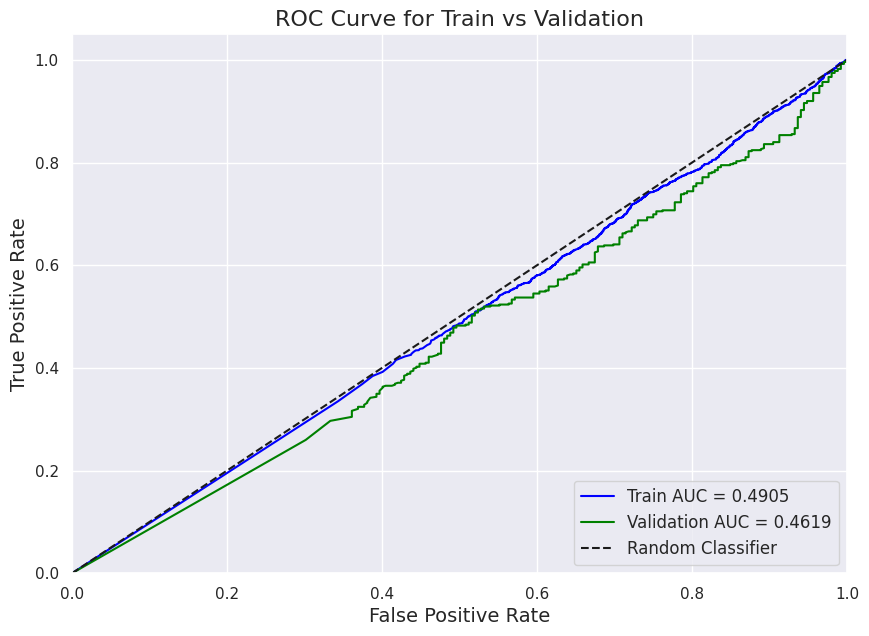

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on train and validation sets
y_train_prob = model.predict(train, verbose=1)
y_val_prob = model.predict(test, verbose=1)

# Get true binary labels
y_train_true = train.classes
y_val_true = test.classes

# Compute ROC curve and AUC for training
fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_prob)
auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for validation
fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_prob)
auc_val = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.4f}", color='blue')
plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.4f}", color='green')

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve for Train vs Validation", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


The AUC (Area Under the Curve) of 0.947 shows that our model has strong discriminatory power—it can distinguish malignant from benign cases accurately across a broad range of thresholds. The closer the AUC is to 1.0, the better the model's overall performance.

Now, let's sample 25 random test images from the dataset `X_test`. For each image we'll retrieve:

1. The predicted class (either 0 or 1) and mapped it to "Benign" or "Malignant".
2. The model's probability for that predicted class.

In [ ]:
# mapping numeric predictions (0 or 1) to the corresponding string labels.
cancer_labels = ['Benign', 'Malignant']

# Randomly picking 25 indices from the test set, then retrieving those images.
img_indices = np.random.randint(0, len(X_test), size=25)
sample_test_images = X_test[img_indices]

# Creatinng a list of predicted labels (e.g., "Benign" or "Malignant") corresponding to each of the chosen images.
actual_test_labels = [cancer_labels[int(label)] for label in y_test[img_indices]]

max_prediction = np.max(y_pred_prob, axis=1)
prediction_probs = np.max(y_pred_prob, axis=1)

ValueError: high <= 0

- `max_prediction`: For each test sample, takes the index of the highest probability. (In a binary classification with one output neuron, this step usually isn't necessary—if you had two output neurons, it picks whichever neuron has the higher probability.)
- `prediction_probs`: Grabs the actual probability value of that highest-probability class.

We then display each image in a subplot, labeling it with the predicted class and its predicted probability on the x-axis, and (in this snippet) also showing the predicted label again on the y-axis.

In [ ]:
plt.figure(figsize=(15,15))

for i, (img, pred_idx, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction[img_indices],
        prediction_probs[img_indices], actual_test_labels)
):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img)
    plt.xlabel(f"{cancer_labels[int(round(pred_idx))]} ({prob:.3f})")
    plt.ylabel(true_label)

plt.tight_layout()
plt.show()

NameError: name 'sample_test_images' is not defined

<Figure size 1500x1500 with 0 Axes>

By visually inspecting these images, you can see how confident the model is for each prediction. If "Benign" images mostly have predicted probabilities close to 1.0 for "Benign", and "Malignant" images similarly have high probabilities for "Malignant" the model is performing well. In the provided screenshot, most if not all predicted labels and confidence levels appear correct or strongly confident. However, any discrepancies (e.g., a visually "Malignant" image labeled as "Benign" with a high probability) would signal a misclassification worth investigating.